In [1]:
# Machine learning based classification of effective and not effective drugs
# Feature importance calculation
# Comparision of ROCAUC-s from machine learning based and similarity based ROC curves
# Calculation of mean of predicteed probabilities

In [2]:
import pandas as pd
import numpy as np

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from scipy import stats

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

# Read in data

In [5]:
tf_act = pd.read_csv('../results/drug_signatures/signatures_bing_gene_dorothea.csv', index_col=0)

In [6]:
chembl_drugs = pd.read_csv('../results/drugs/chembl_drugs.csv', index_col=1)

In [7]:
similarity = pd.read_csv('../results/drug_signatures/similarities_bing_genes.csv', index_col = 0)

In [8]:
samples = ['GSE147507.S5_A549_SARS.CoV.2','GSE147507.S7_Calu3_SARS.CoV.2','GSE148729_Calu3_SARS.CoV.2_24H']

In [9]:
similarity = similarity.loc[samples].T

In [10]:
# select effective and not effective drugs (Chembl database)
effective = chembl_drugs.index
not_effective = tf_act[~tf_act.index.isin(effective)].index

In [11]:
# select labels (effective = 1, not effective = 0)
labels = pd.DataFrame(0, index = tf_act.index, columns=['is_effective'])
labels.loc[effective, 'is_effective'] = 1
labels.loc[not_effective, 'is_effective'] = 0

# Functions

In [12]:
# split data by half (50-50%) for effective and not effective drugs too than append
def create_training_and_crossvalidation_set(effective, not_effective, labels):
    
    tr_eff=np.random.choice(effective,int(len(effective)/2),replace=False)
    cv_eff=list(set(effective) - set(tr_eff))

    tr_noteff=np.random.choice(not_effective,int(len(not_effective)/2),replace=False)
    cv_noteff=list(set(not_effective) - set(tr_noteff))
    
    tr = [*tr_eff, *tr_noteff]
    cv = [*cv_eff, *cv_noteff]

    X_tr = tf_act[tf_act.index.isin(tr)]
    X_cv = tf_act[tf_act.index.isin(cv)]

    y_tr=labels.loc[X_tr.index, 'is_effective']
    y_cv = labels.loc[X_cv.index, 'is_effective']
    
    if (y_tr.index == X_tr.index).all() & (y_cv.index == X_cv.index).all() ==True:
        return X_tr, X_cv, y_tr, y_cv
    else: print('Indices are not in order')

In [13]:
# Random Forest Classifier, predict is_effective probabilities, and calculate feature importance
def classification(X_tr, X_cv, y_tr, y_cv):
    
    clf=RandomForestClassifier(n_estimators=300, random_state=2020, n_jobs =-1)
    clf.fit(X_tr,y_tr)
    y_pred=clf.predict_proba(X_cv)
    feature_imp = pd.Series(clf.feature_importances_,index=tf_act.columns).sort_values(ascending=False)
    
    return y_pred, feature_imp

In [14]:
# Calculate feature importance for 100 (range) random seed and calculate mean of them
# Save y_pred values per seed (range 100) and save to y_pred_dict
y_pred_dict = {}
def calculate_feature_importance(effective, not_effective, labels):
    rng = 100
    for i in range(rng):
        
        print(i, end=', ')
        np.random.seed(i) 
        X_tr, X_cv, y_tr, y_cv = create_training_and_crossvalidation_set(effective, not_effective, labels)
        y_pred, feature_imp = classification(X_tr, X_cv, y_tr, y_cv)
        
        feature_imp = feature_imp.sort_index()
        y_pred_dict[i] = pd.DataFrame(y_pred, index=X_cv.index, columns=['p_not_eff', 'p_eff'])
        
        if i == 0:
            feature_importance = feature_imp
        if i>0:
            feature_importance = feature_importance + feature_imp
            
    feature_importance = feature_importance / rng
    feature_importance = feature_importance.sort_values(ascending=False)
    
    print('done')
    return feature_importance

# Classifying

In [15]:
# calculate feature importance, y_pred for 100 random seed
feature_importance = calculate_feature_importance(effective, not_effective, labels)

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, done


In [16]:
feature_importance.head()

SREBF1    0.016776
SREBF2    0.013069
TFAP2A    0.012663
HNF4A     0.011078
TP63      0.010036
dtype: float64

In [17]:
# Feature importance chembl
feature_importance.to_csv('../results/random_forest_classification/feature_importances_n_300.csv')

# ROC curves

In [18]:
# Caluclate roc curves RF based
# all random seed has different drugs in y_pred
# 100 ROC curves and ROCAUC are calculated

roc_curves_rf_based = {}

for i in y_pred_dict:
    vector = labels.loc[y_pred_dict[i].index]
    
    if ((y_pred_dict[i].index == vector.index).all()) == False:
        print('Error')
        break
        
    fpr, tpr, thresholds = roc_curve(vector['is_effective'], y_pred_dict[i]['p_eff'])
    roc_auc = auc(x=fpr,y=tpr)
    roc_curves_rf_based[i] = [fpr, tpr, roc_auc]

In [19]:
# Calulate ROC curves and ROCAUC based on similarities (per virus (3 selected))
# save curves and ROCAUC values to roc_curves_per_virus dictionary (containing roc_curves_similarity_based dicts)

roc_curves_per_virus = {}
for virus in similarity.columns:
    
    print(virus)
    roc_curves_similarity_based = {}
    
    for i in y_pred_dict:
        vector = labels.loc[y_pred_dict[i].index]

        sim = similarity[[virus]]
        sim = sim.loc[y_pred_dict[i].index]

        if ((y_pred_dict[i].index == vector.index).all()) == False:
            print('Error')
            break
        if ((y_pred_dict[i].index == sim.index).all()) == False:
            print('Error')
            break

        fpr, tpr, thresholds = roc_curve(vector['is_effective'], sim)
        roc_auc = auc(x=fpr,y=tpr)
        roc_curves_similarity_based[i] = [fpr, tpr, roc_auc]
    roc_curves_per_virus[virus] = roc_curves_similarity_based


GSE147507.S5_A549_SARS.CoV.2
GSE147507.S7_Calu3_SARS.CoV.2
GSE148729_Calu3_SARS.CoV.2_24H


In [20]:
# Select ROCAUC values to rocauc dictionary
rocauc = {}
rocauc['rf_based'] = pd.Series(map(lambda curve: curve[2],roc_curves_rf_based.values()), name='rf_based')

for virus in roc_curves_per_virus:
    rocauc[virus] = pd.Series(map(lambda curve: curve[2],roc_curves_per_virus[virus].values()), name=virus)

In [21]:
rocauc_df = pd.DataFrame.from_dict(rocauc)

In [22]:
rocauc_df.to_csv('../results/random_forest_classification/rocaucs_n_300.csv')

### Mean of predicted probabilities

In [23]:
predicted_probabilities_drugs = pd.Series(0.0, index = tf_act.index)
freq_count = pd.Series(0, index = tf_act.index)

In [24]:
for k,probabilities in y_pred_dict.items():
    predicted_probabilities_drugs = predicted_probabilities_drugs.add(probabilities.p_eff, fill_value=0)
    freq_count.loc[probabilities.index] = freq_count.loc[probabilities.index].add(1)

In [25]:
predicted_probabilities_drugs_mean = predicted_probabilities_drugs.divide(freq_count, fill_value=0)

In [26]:
predicted_probabilities_drugs_mean.sort_values().tail()

ciclopirox        0.200788
obatoclax         0.246067
digitoxin         0.254737
heliomycin        0.264706
cytochalasin-d    0.276536
dtype: float64

In [27]:
drug_pred_prob = similarity.copy()

In [28]:
drug_pred_prob['RF_predicted_probabilities'] = predicted_probabilities_drugs_mean

In [29]:
drug_pred_prob.columns = ['GSE147507 A549 SARS-CoV-2', 'GSE147507 Calu3 SARS-CoV-2', 
                         'GSE148729 Calu3 SARS-CoV-2', 'Random Forest Predicted Probabilities']

In [30]:
drug_pred_prob

,GSE147507 A549 SARS-CoV-2,GSE147507 Calu3 SARS-CoV-2,GSE148729 Calu3 SARS-CoV-2,Random Forest Predicted Probabilities
AT1-SHH-09,0.025787,0.103752,0.099418,0.001667
dexamethasone-acetate,0.043213,0.075573,0.082942,0.031926
MW-SHH-97,0.170028,0.171434,0.016707,0.003590
pancuronium,0.112912,0.188854,0.139835,0.013987
L-2167,-0.163297,-0.221272,-0.132270,0.002500
...,...,...,...,...
SA-247714,0.327706,0.227374,-0.044856,0.142160
chromomycin-a3,0.117907,0.000689,-0.093304,0.002016
cytarabine,0.199559,0.115466,0.002919,0.024545
imperatorin,-0.058142,-0.150083,-0.146456,0.000392


In [31]:
drug_pred_prob.to_csv('../results/random_forest_classification/drug_predicted_probabilities_n_300.csv')

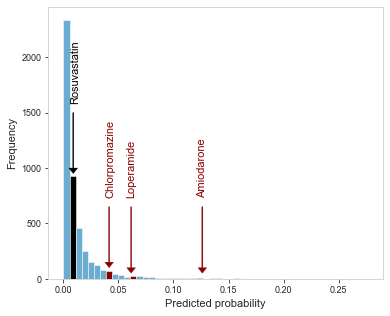

In [32]:
data = drug_pred_prob['Random Forest Predicted Probabilities']
fig, ax = plt.subplots(figsize = (6,5))
N, bins, patches = plt.hist(data, edgecolor='white', linewidth=0.5, bins = 50, color = "#6bacd1")
loper = data['loperamide']
amio = data.loc['amiodarone']
cp = data.loc['chlorpromazine']
rosu = data.loc['rosuvastatin']

for drug in [loper, amio, cp]:
    for i in range(len(bins)):
        if bins[i] > drug:
            patches[i-1].set_facecolor('darkred')
            break       
for drug in [rosu]:
    for i in range(len(bins)):
        if bins[i] > drug:
            patches[i-1].set_facecolor('black')
            break       

            
plt.arrow(rosu+0.001, 1500, 0, -500, head_width=0.008, head_length=50, color='k', linewidth = 0.3)
plt.arrow(cp+0.001, 650, 0, -500, head_width=0.008, head_length=50, color='darkred', linewidth = 0.3)
plt.arrow(amio, 650, 0, -550, head_width=0.008, head_length=50, color='darkred', linewidth = 0.3)
plt.arrow(loper, 650, 0, -550, head_width=0.008, head_length=50, color='darkred', linewidth = 0.3)

plt.text(rosu+0.003, 1600, 'Rosuvastatin', color='k', rotation = 90, ha = 'center', fontsize = 11)
plt.text(cp+0.002, 750, 'Chlorpromazine', color='darkred', rotation = 90, ha = 'center', fontsize =11)
plt.text(amio, 750, 'Amiodarone', color='darkred', rotation = 90, ha = 'center', fontsize =11)
plt.text(loper, 750,'Loperamide', color='darkred', rotation = 90, ha = 'center', fontsize = 11)

plt.xticks(fontsize = 9)
plt.yticks(fontsize = 9)
plt.tick_params(bottom = True, left = True)

plt.xlabel('Predicted probability', fontsize=11)
plt.ylabel('Frequency',  fontsize=11)
ax.grid(False)

# Comparison of predictive accuracy of similarity-based method and random forest-based prediction

In [33]:
rocaucs = pd.read_csv('../results/random_forest_classification/rocaucs_n_300.csv', index_col=0)

In [34]:
rocaucs = rocaucs[['GSE147507.S5_A549_SARS.CoV.2','GSE147507.S7_Calu3_SARS.CoV.2', 
            'GSE148729_Calu3_SARS.CoV.2_24H', 'rf_based']]

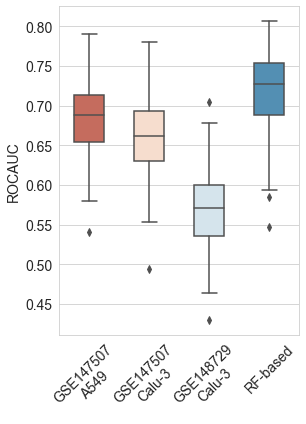

In [35]:
plt.figure(figsize=(4,6))

boxplot = sns.boxplot(data = rocaucs, palette='RdBu', width=0.5)
boxplot.set_xticklabels(['GSE147507\nA549', 'GSE147507\nCalu-3', 'GSE148729\nCalu-3', 'RF-based'], 
                        rotation=45, fontsize = 14)
plt.tight_layout()
plt.ylabel('ROCAUC', fontsize=14)
plt.yticks(fontsize=14)

plt.show()

###### Paired t-test

In [36]:
gse147507_a549 = stats.ttest_rel(rocaucs['GSE147507.S5_A549_SARS.CoV.2'],rocaucs['rf_based'])
gse147507_calu3 = stats.ttest_rel(rocaucs['GSE147507.S7_Calu3_SARS.CoV.2'],rocaucs['rf_based'])
gse148729_calu3 = stats.ttest_rel(rocaucs['GSE148729_Calu3_SARS.CoV.2_24H'],rocaucs['rf_based'])

In [37]:
stat = pd.DataFrame([gse147507_a549, gse147507_calu3, gse148729_calu3], 
                    index = ['GSE147507_A549', 'GSE147507_Calu3', 'GSE148729_Calu3'])
stat.pvalue = stat.pvalue.apply(lambda x: "{:,.2e}".format(x))

In [38]:
stat

,statistic,pvalue
GSE147507_A549,-5.496211,3.02e-07
GSE147507_Calu3,-9.357331,2.76e-15
GSE148729_Calu3,-23.340910,4.89e-42


# Feature importances of the random forest model

In [39]:
feature_imp = pd.read_csv('../results/random_forest_classification/feature_importances_n_300.csv', index_col = 0)

In [40]:
feature_imp_head = feature_imp.head(30)
fitb = pd.concat([feature_imp.head(10), feature_imp.tail(10)])
feature_imp_tail = feature_imp.tail(20)

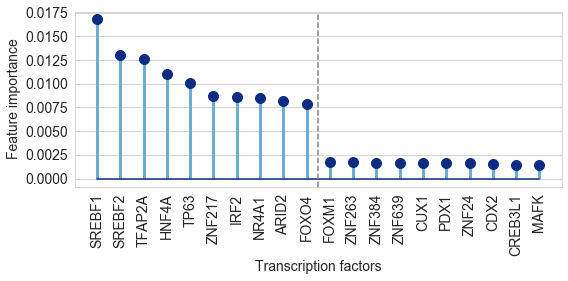

In [41]:
fig, ax = plt.subplots(figsize=(8,4), tight_layout=True)

data = fitb
dark = '#0c2c84'
light = '#6bacd1'
markerline, stemlines, baseline = plt.stem(data['0'],use_line_collection = True) 

plt.setp(baseline, visible = True, color=dark )
plt.setp(stemlines,  linewidth=3, color=light)
plt.setp(markerline,  markersize = 10, color=dark)

plt.xticks(range(len(data)), data.index, rotation=90, fontsize = 14)
plt.yticks(fontsize = 14)
plt.xlabel('Transcription factors', fontsize = 14)
plt.ylabel('Feature importance', fontsize = 14)

plt.axvline(x=9.5, color='gray', linestyle='--')
    
ax.grid(False, axis = 'x')

plt.show()